<a href="https://colab.research.google.com/github/bronya-y/GAN/blob/main/gan%E9%AB%98%E6%96%AF%E5%88%86%E5%B8%83%E6%8B%9F%E5%90%885.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
# from torch.distributions.
import numpy as np
import matplotlib.pyplot as plt

In [68]:
normal_samp = Normal(3,0.5)
data = normal_samp.sample((30000,))
print(data)
data = torch.sort(data)
print(data.values.shape)

tensor([3.1836, 2.4200, 3.5235,  ..., 3.5332, 3.7242, 2.6743])
torch.Size([30000])


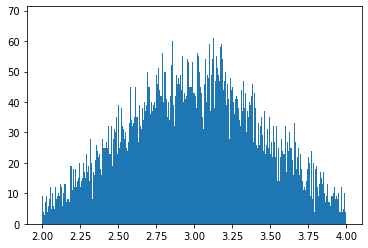

In [69]:
# x1=x
data2 = data.values.numpy()
# print(x,data)
plt.hist(x=data2,bins=1000,range=(2,4))
#第3步：显示图形
plt.show()

In [70]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.xfer = torch.nn.SELU()

    def forward(self, x):
        x = self.xfer( self.map1(x) )
        x = self.xfer( self.map2(x) )
        return self.xfer( self.map3( x ) )

In [71]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.elu = torch.nn.ELU()

    def forward(self, x):
        x = self.elu(self.map1(x))
        x = self.elu(self.map2(x))
        return torch.sigmoid( self.map3(x) )

In [72]:
from torchsummary import summary
gg = Generator(10,20,10)
summary(gg,(10,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]             220
              SELU-2                   [-1, 20]               0
            Linear-3                   [-1, 20]             420
              SELU-4                   [-1, 20]               0
            Linear-5                   [-1, 10]             210
              SELU-6                   [-1, 10]               0
Total params: 850
Trainable params: 850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [73]:
epochs = 50000
G_in = 10 #G的输入长度
G_hid = 100
G_out = 200
D_in = 200  #G_out与D_in应该一样
D_hid = 50
D_out = 1
d_learning_rate = 3e-3
g_learning_rate = 8e-3

data_mean = 3.0
data_stddev = 0.2

d_batch_size = 15
g_batch_size = 10

G = Generator(G_in,G_hid,G_out) #实例化G
D = Discriminator(D_in,D_hid,D_out) #实例化D


def get_real_sampler(mu, sigma):
    dist = Normal( mu, sigma )
    return lambda m, n: dist.sample( (m, n) ).requires_grad_() #lambda用法，lambda 数据：对数据的操作

def get_noise_sampler():
    return lambda m, n: torch.rand(m, n).requires_grad_()  # m*n形状的随机分布数据采样

actual_data = get_real_sampler( data_mean, data_stddev ) #采样高斯分布的函数
noise_data  = get_noise_sampler() #采样随机分布的函数

criterion = nn.BCELoss() #损失函数定义
d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate ) #, betas=optim_betas) #优化器
g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate ) #, betas=optim_betas) #优化器

In [74]:
for epoch in range(epochs):
  d_optimizer.zero_grad()
  real_data = actual_data(d_batch_size,D_in)
  real_target = torch.ones(d_batch_size,1)
  d_r_pred = D(real_data)
  d_r_loss = criterion(d_r_pred,real_target)
  d_r_loss.backward()
  d_optimizer.step()

  d_optimizer.zero_grad()
  noise = noise_data( d_batch_size, G_in )
  fake_data = G( noise ) 
  fake_target = torch.zeros( d_batch_size, 1 )
  d_g_pred = D( fake_data )
  d_g_loss = criterion( d_g_pred, fake_target)  # zeros = fake
  d_g_loss.backward()
  d_optimizer.step()
  # print(d_r_pred.shape,real_target.shape)

  g_optimizer.zero_grad()
  noise = noise_data( g_batch_size, G_in )
  fake_data = G( noise )
  fake_decision = D( fake_data )
  error = criterion( fake_decision, torch.ones( g_batch_size, 1 ) )  # we want to fool, so pretend it's all genuine
  error.backward()
  g_optimizer.step()

torch.save(D, "/content/model/D.pth") 
torch.save(G, "/content/model/G.pth")



In [75]:
# dd = Generator(G_in,G_hid,G_out) #实例化G
GG =torch.load("/content/model/G.pth")

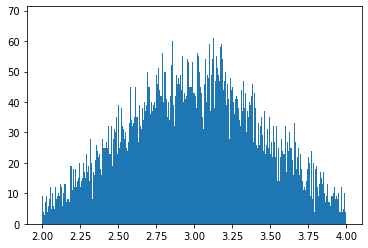

In [76]:
# x1=x
data2 = data.values.numpy()
# print(x,data)
plt.hist(x=data2,bins=1000,range=(2,4))
#第3步：显示图形
plt.show()

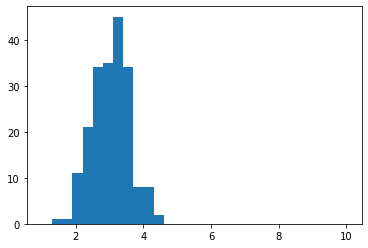

In [82]:
noise = noise_data( 1, G_in )
fake_data = GG( noise ) 
nnp =np.zeros(200,)
for i in range(200):
  nnp[i] = fake_data[0][i]
plt.hist(x=nnp,bins=30,range=(1,10))
plt.show()